<a href="https://colab.research.google.com/github/MarioBolanos/Modelado2020_2/blob/master/Runge_Kutta_Adaptativo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Métodos adaptativos de Runge-Kutta

___


Este módulo ofrece una breve introducción al concepto de "métodos adaptativos de tamaño de paso" y "pares integrados de Runge-Kutta" para resolver ecuaciones diferenciales ordinarias (EDO). Vamos a resolver EDO de primer orden de la forma

$$
\frac {\text{d}} {\text{d} t} y (t) = f (y (t), t).
$$

Es conveniente considerar el parámetro $ t $ como "tiempo" y $ y $ como "posición" en el tiempo $ t $. El concepto de tamaño de paso adaptativo se generaliza fácilmente para EDO de orden superior, de la misma manera que el método Euler explícito menos sofisticado se puede generalizar al método de Runge-Kutta (de cuarto orden).

### Idea básica de los métodos adaptativos de Runge-Kutta
Un método adaptativo de Runge-Kutta es un método que utiliza dos órdenes de aproximación diferentes (a menudo uno con orden $ p $ y otro con orden $ p + 1 $) para obtener una estimación del error de truncamiento local. Por lo tanto, es posible decidir más o menos qué precisión queremos que tenga la solución cambiando el tamaño del paso para cada iteración. Otra ventaja de los métodos de tamaño de paso adaptativo es que podemos tener más pasos donde sea necesario y menos pasos en otros lugares (a continuación se muestra un ejemplo). Sin embargo, como es evidente, estos métodos suelen requerir más cálculos.

Siguiendo esta idea, podemos desarrollar fácilmente pares de métodos de Runge-Kutta (RK) (uno con orden $ p $ y otro con orden $ p + 1 $) que comparten varios de los cálculos necesarios. Esto nos permite estimar el error de truncamiento local casi sin cálculos adicionales. Estos pares se denominan $ \textbf{pares de Runge-Kutta incrustados} $.

Primero, importamos las bibliotecas necesarias y establecemos algunos parámetros de figuras comunes.

In [15]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Set common figure parameters
newparams = {'figure.figsize': (10, 4), 'axes.grid': True,
             'lines.linewidth': 1.5, 'lines.markersize': 10,
             'font.size': 14}
plt.rcParams.update(newparams)

### Implementar funciones

Es hora de definir algunas funciones que van a calcular dos órdenes de aproximación diferentes para el lado derecho (RHS) de la EDO, a saber $ f (y (t), t) $. Las siguientes funciones son algunos ejemplos de métodos adaptativos de Runge-Kutta. En [2] se proporciona un algoritmo para derivar estos métodos.

In [16]:
def odesolver12(f, t, y, h):
    """Calcule el siguiente paso de un problema de valor inicial (PVI) de
    una EDO con un RHS descrito por f, con un orden 1 aprox.
    (Método Eulers) y un pedido 2 aprox. (Regla del punto medio). Esto es
    el par RK integrado más simple.
    Parámetros:
        f: función. RHS de ODE.
        t: Tiempo actual.
        y: Posición actual.
        h: Tamaño de paso.
    Devoluciones:
        q: aprox de orden 1.
        w: aprox de orden 2
     """

    s1 = f(t, y)
    s2 = f(t+h, y+h*s1)
    w = y + h*s1
    q = y + h/2.0*(s1+s2)
    return w, q

def odesolver23(f, t, y, h):
    """ Calcule el siguiente paso de un IVP de una EDO con un RHS
    descrito por f, con un orden 2 aprox. (Trapecio explícito
    Método) y un pedido de 3 aprox. (RK de tercer orden).
    Parámetros:
        f: función. RHS de ODE.
        t: Tiempo actual.
        y: Posición actual.
        h: Tamaño de paso.
    Devoluciones:
        q: aprox de orden 2
        w: aprox de orden 3
    """
    s1 = f(t, y)
    s2 = f(t+h, y+h*s1)
    s3 = f(t+h/2.0, y+h*(s1+s2)/4.0)
    w = y + h*(s1+s2)/2.0
    q = y + h*(s1+4.0*s3+s2)/6.0
    return w, q

def odesolver45(f, t, y, h):
    """ calcula el siguiente paso de un IVP de una EDO con un RHS
    descrito por f, con un orden 4 aprox. y un pedido de 5 aprox.
    Parámetros:
        f: función. RHS de ODE.
        t:  Tiempo actual.
        y:  Posición actual.
        h:  Longitud del paso.
    Devoluciones:
        q: aprox de orden 4
        w: aprox de orden 5
    """
    s1 = f(t, y)
    s2 = f(t+h/4.0, y+h*s1/4.0)
    s3 = f(t+3.0*h/8.0, y+3.0*h*s1/32.0+9.0*h*s2/32.0)
    s4 = f(t+12.0*h/13.0, y+1932.0*h*s1/2197.0-7200.0*h*s2/2197.0+7296.0*h*s3/2197.0)
    s5 = f(t+h, y+439.0*h*s1/216.0-8.0*h*s2+3680.0*h*s3/513.0-845.0*h*s4/4104.0)
    s6 = f(t+h/2.0, y-8.0*h*s1/27.0+2*h*s2-3544.0*h*s3/2565+1859.0*h*s4/4104.0-11.0*h*s5/40.0)
    w = y + h*(25.0*s1/216.0+1408.0*s3/2565.0+2197.0*s4/4104.0-s5/5.0)
    q = y + h*(16.0*s1/135.0+6656.0*s3/12825.0+28561.0*s4/56430.0-9.0*s5/50.0+2.0*s6/55.0)
    return w, q

### Decidir el tamaño del paso adaptativo

En las definiciones de funciones anteriores, $ w $ representa la aproximación de orden más bajo y $ q $ la aproximación de orden superior. Cuando $ h $ es pequeño, una buena estimación de error para $ w $ es

$$
e_ {i + 1} \approx\left | q_ {i + 1} -w_ {i + 1} \right |.
$$

La idea es que uno puede realizar un paso del cálculo y luego verificar el error estimado $ e_i $, o el error relativo $ e_i / \left | w_i \right | $. Si el error es mayor que una tolerancia elegida, $ TOL $, el tamaño del paso se reduce en una cantidad predefinida, a menudo configurada para duplicar o reducir a la mitad el tamaño del paso.

Siempre queremos minimizar nuestro uso de recursos computacionales, pero aún estar dentro de la tolerancia dada. Por lo tanto, sería una buena idea cambiar el tamaño del paso para el siguiente paso solo si, por ejemplo, el error del paso actual es menor que $ TOL / 20 $. Sin embargo, existen formas más sofisticadas de cambiar el tamaño del paso.

Si dejamos que la tolerancia esté dada por el error relativo, $ TOL> e_i / \left | w_i \right | $, y asumimos que $ w $ es del orden $ p $, el error viene dado por $ e_i = \mathcal { O} (h ^ {p + 1}) $. Suponiendo que

$$
e_i \approx \xi h_i ^ {p + 1},
$$

para un $\xi $ constante, el tamaño de paso más cercano a la tolerancia viene dado por

$$
TOL \cdot \left | w_i \right | = \xi h ^ {p + 1}.
$$

Esto produce

$$
\tilde h = \left (\frac {TOL \cdot | w_i |} {e_i} \right) ^ {1 / {p + 1}} h_i,
$$

donde $ \tilde h $ es el valor ideal para el siguiente tamaño de paso. Sin embargo, a menudo se agrega un factor de seguridad, de modo que el siguiente tamaño de paso pasa a ser, por ejemplo, $ h_ {i + 1} = 0.8 \cdot \tilde h $. Además, a menudo usamos $ e_i / \max (w_i, \theta) $ $ (\theta> 0) $ en lugar del error relativo para proteger contra $ w_i $ pequeños.

Este algoritmo para la variación del tamaño del paso se deriva de $ w_i $, la aproximación de orden más baja. Sin embargo, dado que la aproximación de orden superior $ q_i $ está disponible (sin cálculo adicional), a menudo se usa para evaluar el siguiente paso.

La forma más sencilla de visualizar el método de tamaño de paso adaptativo es con ejemplos.

### Ejemplo 1
Primero elegimos el RHS de la ODE para que sea

$$
f (y (t), t) = t - 2ty,
$$

que tiene la solución analítica $ \frac {1} {2} (1-e ^ {- t ^ 2}) $. Definamos estas funciones y sigamos resolviendo la EDO usando el método RK incrustado más simple con una aproximación de orden 1 y orden 2. Generalizamos la implementación del método adaptativo RK para no repetirnos.

In [17]:
def RHS1(t, y):
    return t - 2*t*y

def analytical(t, y):
    return 0.5*(1-np.exp(-t**2))

def rk_adaptive(ode, rhs, y0=0.0, t0=0.0, TOL=1e-04, theta=1e-02, tmax=1.0):
    """ Realice un método RK adaptativo.
    Parámetros:
        oda: función. Solucionador de ODE.
        rhs:  RHS de ODE.
        y0:  opcional. Posición inicial.
        t0:  opcional. Tiempo inicial.
        TOL:  opcional. Tolerancia al error relativo.
        theta:  opcional. Constante "protectora".
        tmax:  opcional. Fin del intervalo de cálculo.
    Devoluciones:
        y:  Posición.
        t:  Hora.
        yo: Numero de iteraciones
    """
    
    # Asignar listas para almacenar posición y hora y configurar
    # condiciones iniciales.
    y = []
    t = []
    y.append(y0)
    t.append(t0)
    
    # Establecer el tamaño del paso inicial y declarar el número entero de iteración
    h = 1.0
    i = 0
    
    while (t[i] < tmax):
        # Obtenga dos aproximaciones diferentes
        w, q = ode(rhs, t[i], y[i], h)
        # Estimación de error
        e = abs((w-q)/max(w, theta))
        # Si es mayor que TOL, disminuya la longitud del paso
        if (e > TOL):
            h = 0.8*(TOL*e)**(1/5)*h
            # Obtenga dos nuevas aproximaciones
            w, q = ode(rhs, t[i], y[i], h)
            # Estimar nuevo error
            e = abs((w-q)/max(w, theta))
            # Si aún es mayor que TOL, reduzca a la mitad la longitud del paso hasta que sea menor
            while (e > TOL):
                h = h/2.0
                # Nuevas aproximaciones
                w, q = ode(rhs, t[i], y[i], h)
                # Nueva estimación de error
                e = abs((w-q)/max(w, theta))
        # Almacene la aproximación de orden más alto como el siguiente valor y
        y.append(q)
        # Almacene el tiempo actual + tamaño de paso como la próxima vez
        t.append(t[i] + h)
        # Incrementar el número de paso
        i += 1
        # Compruebe si e es demasiado pequeño, si es así, tamaño de paso doble
        if (e < 0.1*TOL):
            h = h*2.0
    
    return y, t, i

In [30]:
# Calcule la posición en función del tiempo usando el 
# Runge-Kutta adaptativo odesolver12 definido arriba
pos, times, iterations = rk_adaptive(odesolver45, RHS1, y0=0.0, t0=0.0, TOL=1e-02, theta=1e-03, tmax=1.0)

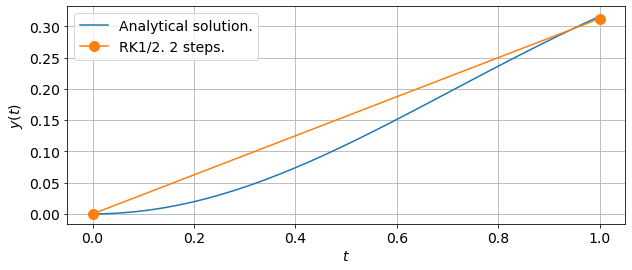

In [31]:
# plot
plt.figure()

# Gráfico analítico
ta = np.linspace(0, times[iterations])
ya = analytical(ta, 0)
plt.plot(ta, ya , label='Analytical solution.')

# RK1 / 2 grafica 
plt.plot(times, pos, '-o' , label='RK1/2. %i steps.' % (iterations+1))
plt.ylabel(r'$y(t)$')
plt.xlabel(r'$t$')
plt.legend(loc="best");

Observamos que el método RK usa 68 pasos siguiendo la curva muy bien, usando un tamaño de paso creciente $ h $ a medida que aumenta $ t $.
### Ejemplo 2
Ahora queremos resolver el IVP dado por

$$
y'(t) = \cos (y (t) \cdot t ^ 2), \quad y (1) = 3,
$$

probar las tres funciones de par RK integradas definidas anteriormente.